# 4.3 Building a simple model


The previous sections of this module have intended to give general and high level concepts about modeling that could be useful in different scenarios. However, we believe that we learn best by doing so we will make this and the next section more practical with a simple modeling exercise using the EQLS dataset.

## Recap
In section 3.5 we determined the variables of interest and we had a look at some of the dependencies - in particular, the dependencies in our _material_ variables('DeprIndex','RuralUrban','AccomProblems','HouseholdSize','Children'). We also visualised the distribution of the Deprivation Index (`DeprIndex`) for different categores of the Self Reported Health (`SRH`) and found that there was a obvious relationship between these variables. Furthermore, following previous research done on the topic and for simplicity, we decided to binarise our variable of interest `SRH` in two categories of `Fair` and `Poor` health. 

## Data processing 

Let's start building a simple model attempting to predict `SRH` using `DeprIndex` using data from the UK. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
 
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
sns.set_style("white")

First let's load the data in the same way as we did in Section 3.5. We can access the data by downloading the [csv](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=7724#!/details) option from here. Create a folder data in the same root as this notebook. Copy the folder `UKDA-7724-csv` and its contents there.




In [2]:
datafolder = '../m3/data/UKDA-7724-csv/'
df11 = pd.read_csv(datafolder + 'csv/eqls_2011.csv')
df_map = pd.read_csv(datafolder + 'mrdoc/excel/eqls_api_map.csv', encoding='latin1')

In [ ]:
# we are only interested in the UK for this example.
df11 = df11.query('Y11_Country == 27')

To make the manipulation easier we select a subset of the data with only the variables we want and rename them into something more readable.

In [20]:
var_map = {"Y11_Q42": "SRH",
           'Y11_Deprindex': 'DeprIndex',
           "Y11_RuralUrban": "RuralUrban",
           "Y11_Accommproblems": 'AccomProblems',
           "Y11_HHsize": "HouseholdSize",
           "Y11_Q32": "Children",
           "Y11_Incomequartiles_percapita" : "IncomeQuartiles",
           "DV_Q7":"WorkingHours",
           "Y11_ISCEDsimple":"ISCED",
           "Y11_Education": "Education",
           "Y11_SocExIndex":"SocialExclusionIndex",
           "Y11_MWIndex": "MentalWellbeingIndex",
           "Y11_Agecategory":"AgeCategory",
           "Y11_HH2a":"Gender",
           "Y11_Q31":"MaritalStatus",
           "Y11_Country":"Country"
}

df11.rename(columns=var_map, inplace=True)
df11_set = df11[var_map.values()]

In section 3.5 we realised that variables like `WorkingHours`, `IncomeQuartiles` have a lot of missing data, so we decided to not use them in the modeling. 


In [21]:
df11_model = df11_set.drop(columns=['WorkingHours','IncomeQuartiles']).dropna() #we defer imputation to a later date. For now we remove na.

Finally, we must dichotomise our `SRH` variable.

In [23]:
# dichotomoise SRH
df11_model['SRH_binary'] = df11_model.SRH.apply(lambda x: 1 if float(x) <= 3 else 0)

## Logistic regression 

Recall from 4.2 that a logistic regression model is: 


$$
\log\left(\frac{p({\bf x})}{1 - p({\bf x})}\right) = \beta_0 + \beta_1 x_1 + \ldots  + \beta_{p - 1} x_{p - 1}
$$


The odds of something are the probability of it happening divided by the probability of it not happening:

$$ odds(x) = \frac{p(x)}{1 - p(x)} $$

Let's have a simple example. Say you have a bag of 5 balls, with 4 red and 1 blue. The probability of drawing a red ball is $\frac{4}{5}$, and the probability of drawing a blue ball is $\frac{1}{5}$. The probability of drawing a blue ball is the same as the probability of _not drawing a red ball_, which is $1-P(red) = 1-\frac{4}{5} = \frac{1}{5}$.

Now, the odds of drawing a red ball is related but not identical to the probability of drawing of a red ball. Instead, it is a measure of how likely drawing a red ball is _in comparison to_ not drawing a red ball. In our simple example we can see the difference. There are four times as many red balls as blue, so you are four times as likely to draw one. The probability, in contrast, is 80%. 

So:

$$ odds(red) = \frac{P(red)}{1-P(red} = \frac{\frac{4}{5}}{1-\frac{4}{5}} = \frac{\frac{4}{5}}{\frac{1}{5}} = 4 $$


**Why do we use log(odds)?**

The left side of the figure below shows the odds of a binary outcome with different probabilities for p(x). You can see that as $p(x)$ becomes closer to 1, $1-p(x)$ becomes infinitesimal, so the odds tend towards infinitely large. 


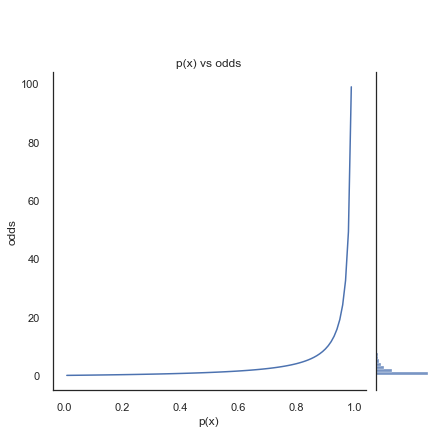

In [4]:
p = np.linspace(.01,.99,100)
odds = p / (1-p)

g = sns.JointGrid()
ax = sns.lineplot(x=p, y=odds, ax=g.ax_joint)
sns.histplot(y=odds, ax=g.ax_marg_y)
g.ax_marg_x.set_axis_off()
ax.set(xlabel='p(x)', ylabel='odds', title= 'p(x) vs odds')
plt.show()

In regression we want equal probability to be placed to either side of the odds function. Taking the $log(odds)$ transforms the exponential odds into a normally distributed function.
As shown below.

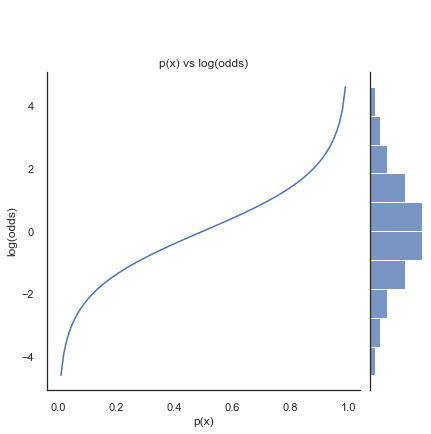

In [5]:
g = sns.JointGrid()
ax =sns.lineplot(x=p, y=np.log(odds), ax=g.ax_joint)
sns.histplot(y=np.log(odds), ax=g.ax_marg_y)
g.ax_marg_x.set_axis_off()
ax.set(xlabel='p(x)', ylabel='log(odds)', title= 'p(x) vs log(odds)')
plt.show()

Here from $p(x)$ we are getting $logit(x)$. To convert $logit(x)$ into a categorical variable $y={0,1}$ we need a probability, let's call it $\hat{p}$, so that we can state that if $\hat{p}\geq0.5$ then $y=1$.

The **sigmoid** function is the inverse of the logit function. If we say that the output of $logit(x)$ is $\hat{x}$, then:

$$ \frac{1}{1 + e^{-\hat{x}}} $$

The intuition is as follows. 

- A fraction with $1$ as the numerator always has a maximum of $1/1 = 1$. As the denominator grows, the value gets closer to $0$, but never below it. 
- $x^{-y}  = \frac{1}{x^y}$, so $e^{-\hat{x}} = \frac{1}{e^{\hat{x}}}$
- $e^{log(odds)} = odds$ So $e^{-log(odds)} = \frac{1}{odds}$. The inverse of the odds how more likely an event is to _not_ happen. 
- So, the sigmoid function is actually $\frac{1}{1+\frac{1}{odds}}$. In other words, when the odds are high the sigmoid function is close to 1, as they decrease the sigmoid function goes towards zero, bounded by zero and 1. 
- This latter function cancels out to $p(x)$. 

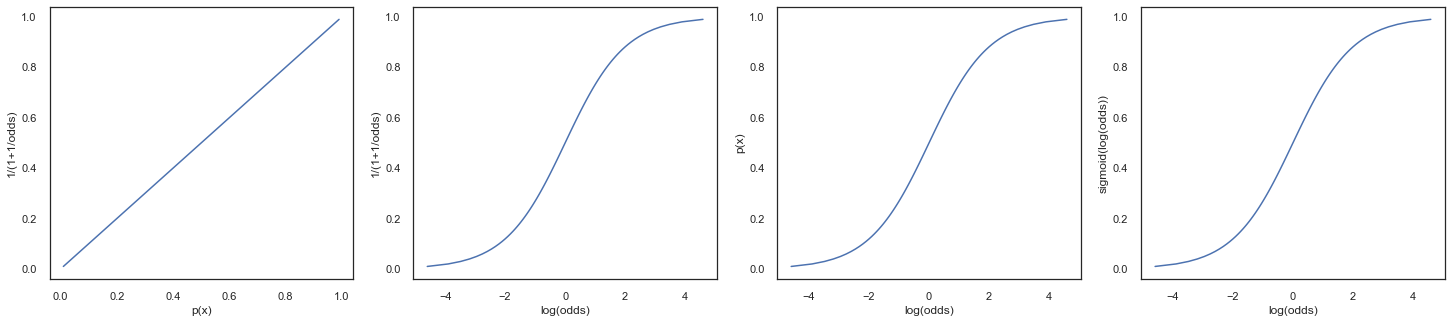

In [6]:
fig, ax = plt.subplots(1,4, figsize=(25,5))

sigm = lambda x: 1/ (1+np.exp(-x))
sigmoid = 1/ (1+(1/odds))
ax[0].plot(p, sigmoid)
ax[0].set(xlabel='p(x)', ylabel='1/(1+1/odds)')
ax[1].plot(np.log(odds), sigmoid)
ax[1].set(xlabel='log(odds)',ylabel='1/(1+1/odds)')
ax[2].plot(np.log(odds), p)
ax[2].set(xlabel='log(odds)', ylabel = 'p(x)')
ax[3].plot(np.log(odds), sigm(np.log(odds)))
ax[3].set(xlabel='log(odds)', ylabel = 'sigmoid(log(odds))')

plt.show()


Now we have converted our logodds to p(x) we can put in decision boundaries. 

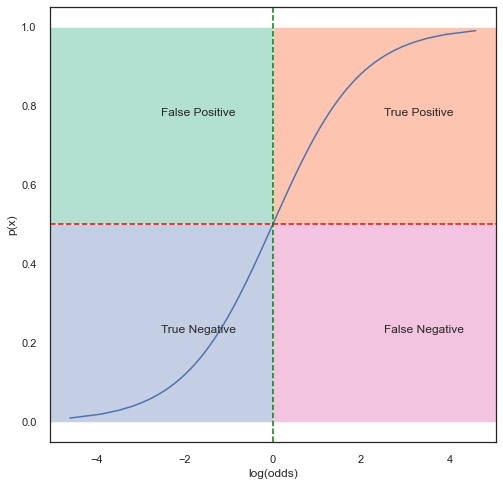

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

plt.plot(np.log(odds), sigm(np.log(odds)))
plt.axhline(y=.5, ls='dashed', c='red')
plt.axvline(x=0, ls='dashed', c='green')
ax.set(xlabel='log(odds)', ylabel = 'p(x)')

cmap = sns.color_palette("Set2", n_colors=4)


ax.axhspan(.5, 1, xmin=0, xmax= .5, facecolor=cmap[0], alpha=0.5)
ax.axhspan(.5, 1, xmin=.5, xmax= 1, facecolor=cmap[1], alpha=0.5)
ax.axhspan(0, .5, xmin=0, xmax=.5, facecolor=cmap[2], alpha=.5)
ax.axhspan(0, .5, xmin=.5, xmax=1, facecolor=cmap[3], alpha=.5)


ax.annotate("False Positive", xy=(.25,.75), xycoords='axes fraction')
ax.annotate("True Positive", xy=(.75,.75), xycoords='axes fraction')
ax.annotate("False Negative", xy=(.75,.25), xycoords='axes fraction')
ax.annotate("True Negative", xy=(.25,.25), xycoords='axes fraction')


plt.show()


Let's return to our model. 

In first simplified model is:
    $$ logit(p(x)) = intercept + \beta_1*deprindex $$
    
We now remind ourselves of our data.

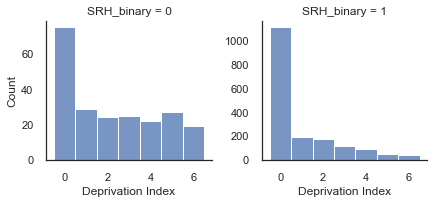

In [8]:
g = sns.FacetGrid(df11_model, col="SRH_binary", sharey=False)
g.map_dataframe(sns.histplot, 'DeprIndex',binwidth=1,binrange=[-0.5,6.5])
g.set_axis_labels("Deprivation Index", "Count")
plt.show()


Notice that the mode is zero in both cases, but there is a much higher proportion of `DeprIndex` scores in [3-6] when SRH = 0 compared to when SRH = 1. From this we can explore some of our expected modelling outcomes before we even fit a model. Note that the logodds are predicted by an intercept _added_ to a scaled predictor. The logistic function that we saw above is monotonic, in that it is _always increasing_ so can only model a change in one direction. So, we already know that:

- As `DeprIndex` increases the odds of SRH_binary=1 will decrease
- There will be many false negatives (all the zeros in SRH_binary = 0)
- There will only be a few false positives.
- Most of the responses will be true positives.

In [9]:
import statsmodels.api as sm

data = df11_model['DeprIndex']
# Intercept is not added by default in Statsmodels, we need to add a constant (and array of 1s) for intercept
X_atr = sm.add_constant(data) 
#Create model instance
logit_model = sm.Logit(df11_model.SRH_binary.values, X_atr) 
result = logit_model.fit() #Fit model

intercept = np.array(result.params[0])
coef1 = np.array(result.params[1])

print(result.summary())


/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.325695
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1994
Model:                          Logit   Df Residuals:                     1992
Method:                           MLE   Df Model:                            1
Date:                Tue, 21 Sep 2021   Pseudo R-squ.:                 0.06477
Time:                        12:13:42   Log-Likelihood:                -649.44
converged:                       True   LL-Null:                       -694.42
Covariance Type:            nonrobust   LLR p-value:                 2.433e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6184      0.102     25.760      0.000       2.419       2.818
DeprIndex     -0.3504      0.

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Now we have fitted our model let us explore it.

We will explore the bones of the model so we understand what the model thinks is going on in the data.

Interpreting the model is the first step in model evaluation. In section 4.3 _Evaluating and Validating Models_ we will assess model performance in more detail.


First, remember that models are ignorant. They only know about the information we have given them. In our case this means that the model does not know that `DeprIndex` is an ordinal value, rather it thinks it is continuous. This means that _according to the model's universe_ values less than zero are allowed in `DeprIndex`, as well as values greater than 6. Whether this is an issue or not depends on context and the conclusions one is drawing.

After the fit we have our intercept and coef, so we can predict the log-odds, and p(x) using what we've learned above.

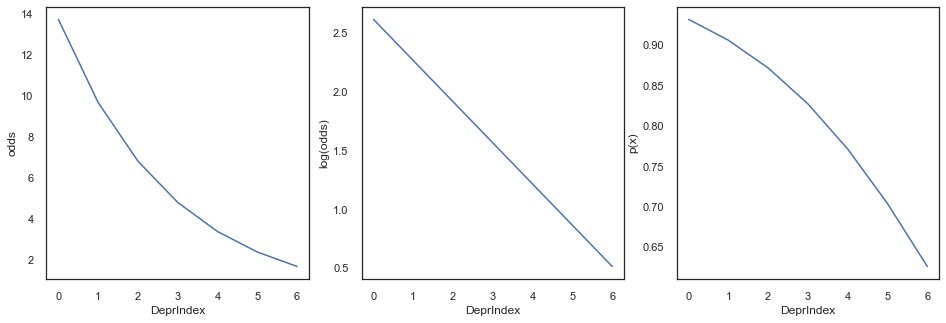

In [10]:
x = list(set(df11_model.DeprIndex.values))

fig, axes = plt.subplots(1,3, figsize=(16,5))


logodds = intercept + coef1*x
odds = np.exp(logodds)
probs = sigm(logodds)

axes[0].plot(x,odds)
axes[0].set_ylabel('odds')
axes[1].plot(x,logodds)
axes[1].set_ylabel('log(odds)')
axes[2].plot(x,probs)
axes[2].set_ylabel('p(x)')
for ax in axes: ax.set_xlabel('DeprIndex')
plt.show()

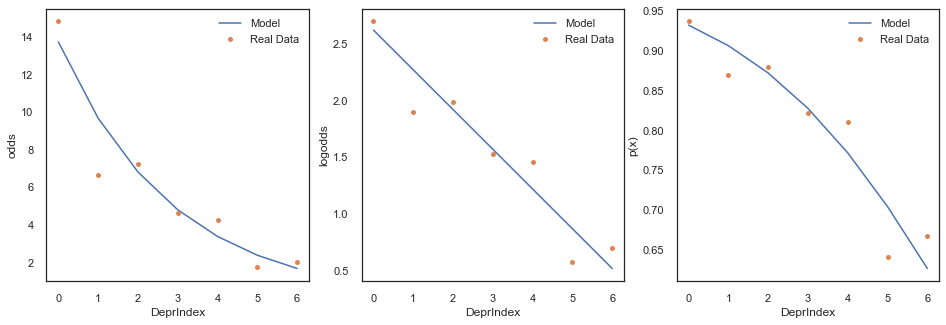

In [11]:
df_lo=pd.pivot_table(df11_model, index=['DeprIndex'], values='SRH_binary', aggfunc=lambda x: np.mean(x))

px=df_lo.SRH_binary.values

x = list(set(data))
x.sort()
fig, axes = plt.subplots(1,3, figsize=(16,5))

odds = np.exp(logodds)
probs = sigm(logodds)

axes[0].plot(x,odds, label='Model')
axes[0].plot(x, px / (1-px), '.', label='Real Data', ms=10)
axes[0].set_ylabel('odds')
axes[1].plot(x,logodds, label='Model')
axes[1].plot(x, np.log(px / (1-px)), '.', label='Real Data', ms=10)
axes[1].set_ylabel('logodds')
axes[2].plot(x,probs, label='Model')
axes[2].plot(x,px, '.', label='Real Data',ms=10)
axes[2].set_ylabel('p(x)')

for ax in axes: 
    ax.set_xlabel('DeprIndex')
    ax.legend()
plt.show()


Note that p(x) on the right looks nothing like our nice sigmoid curve. What's happening here? 

We can see from the odds that even with `DeprIndex` is 6 (highest deprivation) the variable SRH is around 2 times more likely to be 1 (good health) rather than 0. So, our model current predicts `SRH_binary == 1` for _every single_ output of `DeprIndex` in our dataset.

This seems like strange behaviour. We know there are zeroes in our dataset, so does predicting 100% good health mean that our model is bad? 

In the next set of plots we plot the real data on top of the model regression lines.


We have estimate $p(x)$ directly from the data for each category. If you have a set of {0,1}, the the proportion of ones is simply the mean. From this proportion we calculate the odds and log odds.

You can see that logistic model has learned the data pretty well, even though when we binarise the output it is clearly not predicting any poor health.

This is because the predicted binarisation is sort of a hack to get a single predicted classification. What the logistic regression really learns about pretty well is the ratio of responses. If we look at the proportions of good health to poor health in the panel plot below we can see that _even at the highest deprivation index_ we have approximately double the amount of 'good health' to 'poor health'. This is what the model has learned. 

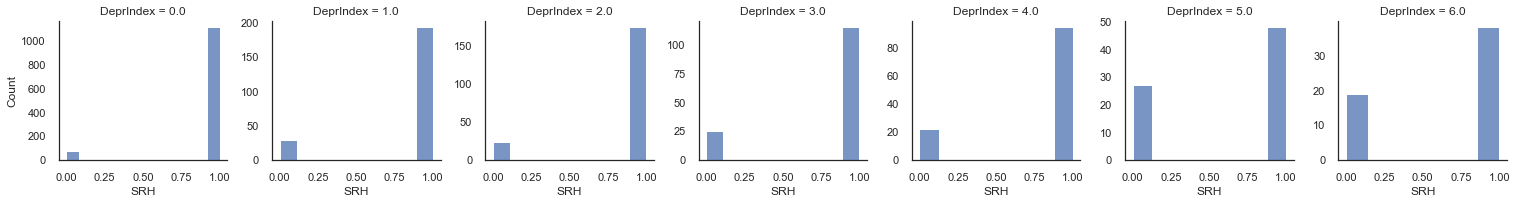

In [12]:
g = sns.FacetGrid(df11_model, col="DeprIndex", sharey=False)
g.map_dataframe(sns.histplot, 'SRH_binary')
g.set_axis_labels("SRH", "Count")
plt.show()

                        

This feels like magic. How does it learn this? 

[Comments]
<!-- 

Talk about bernouilli distribution. And maximum likehihood. This can be done quickly.

-->

- Fit a line between SHR and log odds. 
- The translate log(odds) back to probabilities and comput log likelihood. Sum the log of probabilities.

- The fitted coeffient reflect the change of log odds of each increment on the ordinal category (assuming the predictor has a linear impact).



Remember that the model thinks `DeprIndex` is a continuous variable. If we predict $P(x)$ along a much wider scale than our dataset we get a better idea of the probability curve. 

When two binary outcomes are equally likely, $odds=1, log(odds)=0, \text{and} p(x)=.5$. We can use this knowledge to calculate the decision boundary, meaning the point along the `DeprIndex` scale where the regression model changes its prediction of which outcome is more likely:

$$ 0 = intercept + \beta_1*deprindex $$
$$ \frac{-intercept}{\beta_1} = deprindex $$ 

In the current model this is 7.48.

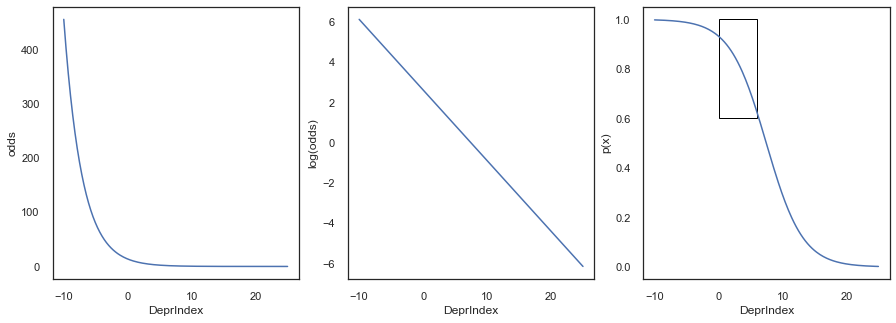

The Decision Boundary is at: 7.47159598984882


In [13]:
x = np.linspace(-10,25,200)
# create a function that starts at p(x) instead of x.

fig, axes = plt.subplots(1,3, figsize=(15,5))

logodds = intercept + coef1*x
odds = np.exp(logodds)
probs = sigm(logodds)

axes[0].plot(x,odds)
axes[0].set_ylabel('odds')
axes[1].plot(x,logodds)
axes[1].set_ylabel('log(odds)')
axes[2].plot(x,probs)
axes[2].set_ylabel('p(x)')
axes[2].add_patch(plt.Rectangle((0,.6),6,.4, fill=False, edgecolor="black"))
for ax in axes: ax.set_xlabel('DeprIndex')
plt.show()



print(f"The Decision Boundary is at: {(-intercept) /coef1}")

Accuracy: 0.8891675025075225
Precision: 0.8891675025075225
Recall: 1.0


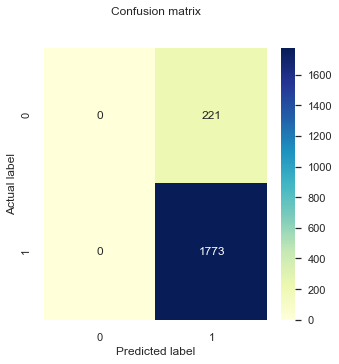

In [14]:
### Move this, F1, and ROC into the evaluating models section.

from sklearn import metrics

x = df11_model.SRH_binary.values

# performing predictions on the test datdaset
yhat = result.predict(X_atr)
y = list(map(round, yhat))


cnf_matrix = metrics.confusion_matrix(x, y)
cnf_matrix                                                                           


def plt_cnf_mat(cnf_matrix, ax, class_names=[0,1]):
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.set_title('Confusion matrix', y=1.1)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    
    
fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix, ax)


print("Accuracy:",metrics.accuracy_score(x, y))
print("Precision:",metrics.precision_score(x, y))
print("Recall:",metrics.recall_score(x, y)) # what is recall? 

# Something
- Disscuss that in the next section we will discuss performance, and as we are discting the model lets add another variable. 

You can see here the no negative values get predicted and the overwelming majority of responses are true positives. Let's get this as a proportion of amount of actual labels in of each category. 

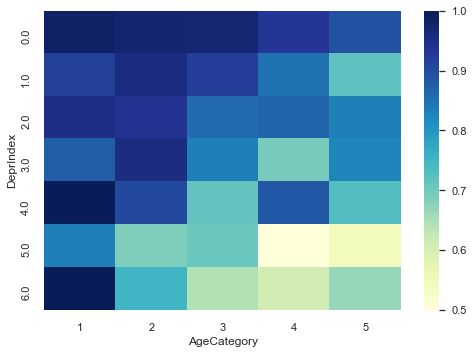

In [15]:
df=pd.pivot_table(df11_model, index=['DeprIndex'], values='SRH_binary', columns=['AgeCategory'], aggfunc=lambda x: np.mean(x))
sns.heatmap(df, cmap="YlGnBu")

plt.show()

In [16]:

data = df11_model[['AgeCategory','DeprIndex']]
X_Age_Dep = sm.add_constant(data) #add constant for intercept
logit_model2 = sm.Logit(df11_model.SRH_binary.values, X_Age_Dep) #Create model instance
result2 = logit_model2.fit() #Fit model

px = result2.predict(X_Age_Dep)

print (result2.summary())

Optimization terminated successfully.
         Current function value: 0.315267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1994
Model:                          Logit   Df Residuals:                     1991
Method:                           MLE   Df Model:                            2
Date:                Tue, 21 Sep 2021   Pseudo R-squ.:                 0.09472
Time:                        12:13:44   Log-Likelihood:                -628.64
converged:                       True   LL-Null:                       -694.42
Covariance Type:            nonrobust   LLR p-value:                 2.725e-29
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.2527      0.300     14.159      0.000       3.664       4.841
AgeCategory    -0.4249    

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


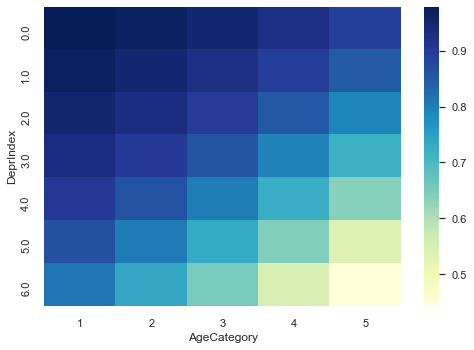

In [17]:
dfm2 = df11_model[['AgeCategory','DeprIndex']].copy()
dfm2['px'] = px


dfm2= pd.pivot_table(dfm2, index=['DeprIndex'], values='px', columns=['AgeCategory'], aggfunc = lambda x: np.mean(x))
sns.heatmap(dfm2, cmap="YlGnBu")
plt.show()

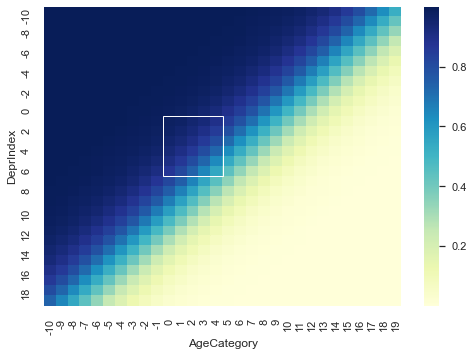

In [18]:
from matplotlib.patches import Rectangle

ages = np.arange(-10,20)
depr = np.arange(-10,20)

X=np.array(np.meshgrid(ages,depr)).reshape(2,-1).T
X_Age_Dep = sm.add_constant(X) #add constant for intercept

px=result2.predict(X_Age_Dep)

temp_df = pd.DataFrame(X, columns=['AgeCategory','DeprIndex'])
temp_df['px'] = px


dfsyn= pd.pivot_table(temp_df, index=['DeprIndex'], values='px', columns=['AgeCategory'], aggfunc = lambda x: np.mean(x))
#print(dfsyn)


sns.heatmap(dfsyn, cmap="YlGnBu")
plt.gca().add_patch(plt.Rectangle((10,11),5,6, fill=False, edgecolor="white"))
# TODO - Rectangle.
# TODO - Decision boundary.

plt.show()

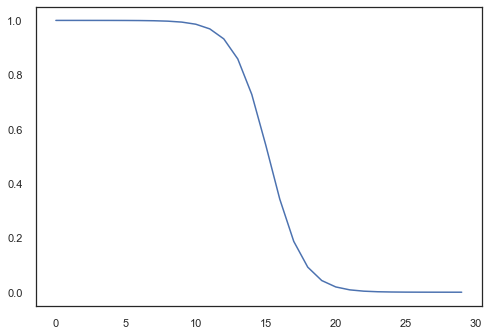

In [19]:
x = np.array(dfsyn).diagonal()
plt.plot(np.arange(0,len(x)),x)
plt.show()

QUESTIONS = TODO LIST (in comment - click to exponse)

<!-- 

GENERAL NOTES: 

For us: How are regression coefficients fitted? MLE using the bernouilli likelihood to evaluate the dataset against the predicted p(x) from

It strikes me that a nice way of introducing models is by getting averages of data, and learning the distribution of the data around that average. Make the distinction between learning average patterns and the observations that go into learning those patterns. 

How do we tweak tyhis so it is less 'how to do logistic regression' and more 'how to do modelling'. When reviewing we should advise people to try and notice when something general crops up.

note - 4.1 to include:
- We are harking here by basing our model development almost exclusively on the relationships within the data. 
- we are not prescribing a model
- in modelling for explanation you need to understand the model in detail

-->

TODO list [in comments]
<!-- 

FOR THIS SECTION:

- add text sections to later plots to motivate the choice of another variable. The hacky way that we've done it is to take a slice of DeprIndex and explore which variables still vary across SRH (so are orthogonal to DeprIndex).
- Talk that no we are essentially controlling for age. Age is a confound that has an effect of the independent variable but that we are not interested in directly. 
- We need to introduce odds ratios as a way of assessing the effect of a predictor on the outcome.



- add annotations to plots

- prettify with margin notes etc.

--->


<!--
FOR SECTION 4.4 EVALUATION/VALIDATING:
- Confusion matrix and talk about decision boundaries.
- F1/ROC curves. 
- Train-test-split in an overfitting context



-->



